In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/ColabNotebooks/filtered_en-fr.csv', nrows=100000)
len(df)

100000

In [ ]:
pip install transformers[torch]

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, MT5ForConditionalGeneration

model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
print("Original DataFrame:")
print(df.head())
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Shuffled DataFrame:")
print(df_shuffled.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used

Original DataFrame:
                                                  en  \
0  Give your listeners a signal that you are wrap...   
1  • Federal institutional governance ($3 billion...   
2                 The "placebo" or "healing" effect.   
3                                 VACUUM CLEANERS 10   
4       • 630-A-1992 — Cancellation - Alkan Air Ltd.   

                                                  fr  
0  Exemple : « Pouvons-nous nous permettre de le ...  
1  • Gouvernance des institutions fédérales (3 MM...  
2            L'effet " placebo " ou " de guérison ".  
3                - Remorques servant d'habitation 10  
4         • 630-A-1992 — Annulation - Alkan Air Ltd.  
Shuffled DataFrame:
                                                  en  \
0  It is publicly traded on the Toronto Stock Exc...   
1  11225): took note that this document was refer...   
2  Conceptual framework The notion of intercultur...   
3  Facilitate the integration of ICTs into K–12 l...   
4            

In [ ]:
train_ratio = 0.8
num_rows = len(df_shuffled)
num_train = int(num_rows * train_ratio)
num_validation = num_rows - num_train

train_df = df_shuffled.iloc[:num_train]
validation_df = df_shuffled.iloc[num_train:]
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
train_df.to_csv('train.csv', index=False)
validation_df.to_csv('validation.csv', index=False)


print("Training dataframe shape:", train_df.shape)
print("Validation dataframe shape:", validation_df.shape)

Training dataframe shape: (80000, 2)
Validation dataframe shape: (20000, 2)


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
prefix = 'translate English to French: '

In [ ]:
pip install datasets

In [ ]:
def pair_columns(dataframe):
    text_pairs = []
    for i in range(0, dataframe.shape[0]):
        text_pairs.append((dataframe['en'][i], dataframe['fr'][i]))
    return text_pairs

In [ ]:
def preprocess_function(text_pairs):
    en_sentence, fr_sentence = zip(*text_pairs)
    inputs = [prefix + str(text) for text in en_sentence]
    targets = fr_sentence
    model_inputs = tokenizer(inputs, text_target=targets, max_length=64, truncation=True)
    return model_inputs

In [ ]:
tokenized_train = preprocess_function(pair_columns(train_df))
tokenized_val = preprocess_function(pair_columns(validation_df))

In [ ]:
print(tokenized_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(tokenized_val)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5ForConditionalGeneration, Trainer, TrainingArguments


class TranslationDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


train_dataset = TranslationDataset(tokenized_train)
val_dataset = TranslationDataset(tokenized_val)
model.train()

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=1000,
    evaluation_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    warmup_steps=500,
    save_total_limit=2,
    learning_rate=2e-5,
)


model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


trainer.train()
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,13.456800,3.012205
2000,4.133900,2.622600
3000,3.622300,2.480284
4000,3.391100,2.395694
5000,3.269200,2.334692
6000,3.147800,2.301902
7000,3.088300,2.262252
8000,3.012800,2.235265
9000,2.950400,2.213183
10000,2.928200,2.195031


Step,Training Loss,Validation Loss
1000,13.456800,3.012205
2000,4.133900,2.622600
3000,3.622300,2.480284
4000,3.391100,2.395694
5000,3.269200,2.334692
6000,3.147800,2.301902
7000,3.088300,2.262252
8000,3.012800,2.235265
9000,2.950400,2.213183
10000,2.928200,2.195031


{'eval_loss': 2.0869534015655518,
 'eval_runtime': 47.3866,
 'eval_samples_per_second': 422.06,
 'eval_steps_per_second': 13.189,
 'epoch': 10.0}

In [ ]:
trainer.save_model("./mt5-finetuned")
model_path = "./mt5-finetuned"
model = MT5ForConditionalGeneration.from_pretrained(model_path)

[{'loss': 13.4568, 'grad_norm': 4.553371429443359, 'learning_rate': 1.9591836734693877e-05, 'epoch': 0.4, 'step': 1000}, {'eval_loss': 3.0122053623199463, 'eval_runtime': 47.3274, 'eval_samples_per_second': 422.588, 'eval_steps_per_second': 13.206, 'epoch': 0.4, 'step': 1000}, {'loss': 4.1339, 'grad_norm': 3.0496935844421387, 'learning_rate': 1.8775510204081636e-05, 'epoch': 0.8, 'step': 2000}, {'eval_loss': 2.6226000785827637, 'eval_runtime': 47.261, 'eval_samples_per_second': 423.181, 'eval_steps_per_second': 13.224, 'epoch': 0.8, 'step': 2000}, {'loss': 3.6223, 'grad_norm': 2.631126880645752, 'learning_rate': 1.795918367346939e-05, 'epoch': 1.2, 'step': 3000}, {'eval_loss': 2.4802844524383545, 'eval_runtime': 47.6332, 'eval_samples_per_second': 419.875, 'eval_steps_per_second': 13.121, 'epoch': 1.2, 'step': 3000}, {'loss': 3.3911, 'grad_norm': 2.326535224914551, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.6, 'step': 4000}, {'eval_loss': 2.3956942558288574, 'eval_runtime': 47

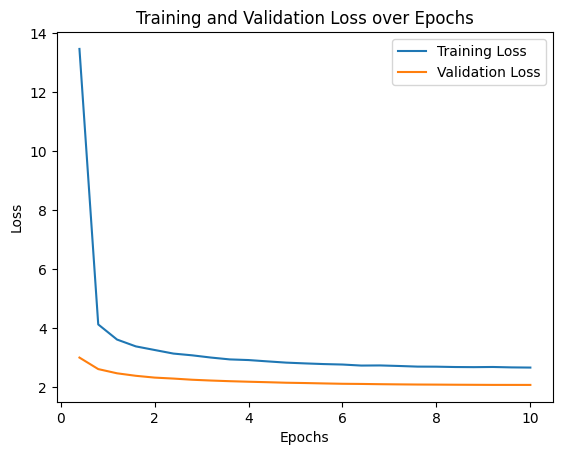

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_logs = trainer.state.log_history
print(train_logs)

train_loss = []
val_loss = []
train_epochs = []

num_steps = 0

for log in train_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        current_epoch = len(val_loss) * training_args.eval_steps / len(train_dataset) * training_args.per_device_train_batch_size
        train_epochs.append(current_epoch)
        num_steps += training_args.eval_steps

min_len = min(len(train_loss), len(val_loss))
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]

plt.plot(train_epochs[:min_len], train_loss, label='Training Loss')
plt.plot(train_epochs[:min_len], val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:

def translate_text(text, model, tokenizer):
    inputs = tokenizer.encode("translate English to French: " + text, return_tensors="pt")
    outputs = model.generate(inputs, max_length=64, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

In [ ]:
pip install torch nltk sacrebleu matplotlib

In [ ]:
def translate_text(text, model, tokenizer):
    inputs = tokenizer.encode("translate English to French: " + text, return_tensors="pt")
    outputs = model.generate(inputs, max_length=64, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

In [ ]:
for index, row in blue_test_df.iterrows():
    original_sentence = row['en']
    translated_sentence = translate_text(original_sentence, model, tokenizer)
    print("Original (English):", original_sentence)
    print("Translated (French):", translated_sentence)
    print()

Original (English): • Freight issue could not be assessed.
Translated (French): • Le problème de transport ne peut pas être examiné.

Original (English): • Potentially - other departments/agencies
Translated (French): • Potentiellement - autres ministères/organismes

Original (English): – The voting is open. Amendment No. 30 is adopted.
Translated (French): – Le vote est ouvert. Amendment No 30 est adopté.

Original (English): However, we should not become overly concerned with literature.
Translated (French): Toutefois, nous ne pouvons pas être très intéressés à la littérature.

Original (English): · Definition of undertaking) (First Chamber, Extended Composition)
Translated (French): · Définition de l'exercice) (seconde Chambre, composition extended)

Original (English): The majority of Spain's population (94%) are Catholic.
Translated (French): La majorité des populations de l'Espagne (94%) sont catholiques.

Original (English): It can reproduce vegetatively or by seed.
Translated (

In [ ]:
df1 = pd.read_csv('dataset.csv', na_values=[''])
print(df1.shape)

(50, 2)


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


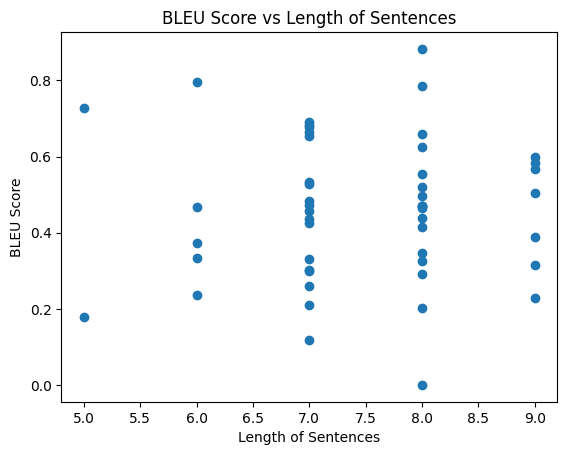

Average BLEU score: 0.4586582378558979


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

reference_translations = [pair[1] for pair in pair_columns(df1)]
model_translations = [translate_text(pair[0], model, tokenizer) for pair in pair_columns(df1)]

def calculate_bleu_score(reference,candidate):
    return corpus_bleu([[ref] for ref in reference], candidate)

bleu_scores = []
for ref, model in zip(reference_translations, model_translations):
    bleu_scores.append(calculate_bleu_score([ref], [model]))
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

sentence_lengths = [len(pair[0].split()) for pair in pair_columns(df1)]
plt.scatter(sentence_lengths, bleu_scores)
plt.xlabel('Length of Sentences')
plt.ylabel('BLEU Score')
plt.title('BLEU Score vs Length of Sentences')
plt.show()

print(f"Average BLEU score: {average_bleu_score}")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
from google.colab import drive
from transformers import Trainer

drive.mount('/content/drive')
model_path = "/content/drive/My Drive/mt5-finetuned"

trainer.save_model(model_path)

Mounted at /content/drive


In [ ]:
import shutil
from google.colab import drive

drive.mount('/content/drive')

source_directory = "/content"

destination_directory = "/content/drive/My Drive/mT5_albert"

shutil.copytree(source_directory, destination_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 